# CS 584 Final Project 
# DETECTING DISCUSSION TOPICS AND SENTIMENT IN REDDIT THREADS <br>


#### Name: Uros Nikolic and Sam Preston
#### Stevens ID: 20017063, 10463953

In [3]:
# Library imports

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pa
import torch
import torch.nn as nn 
from textblob import TextBlob
from torchinfo import summary
from datasets import load_dataset
from tokenizers import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

In [4]:
def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    print('\r' + str_, end='')

In [5]:
# Important pip commands for installing some of the neccesasry libraries. 

#!pip install torch
#!pip uninstall torch torchvision torchaudio

#!pip install -U datasets

#!pip install tokenizers

#!pip install torchinfo

#!pip install evaluate
#!pip install sacrebleu

#!pip install textblob
#python -m textblob.download_corpora


In [6]:
# Testing the Cuda cores on personal machine
print(torch.cuda.is_available())           
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4070 Laptop GPU


In [7]:
# Data extratcion

controversialPosts = pa.read_csv('data/controversial_posts.csv')
controversialPostComments = pa.read_csv('data/controversial_posts_comments.csv')
hotPost = pa.read_csv('data/hot_posts.csv')
hotPostComments = pa.read_csv('data/hot_post_comments.csv')
newPost = pa.read_csv('data/new_posts.csv')
newPostComments = pa.read_csv('data/new_post_comments.csv')
topPost = pa.read_csv('data/top_posts.csv')
topPostComments = pa.read_csv('data/top_posts_comments.csv')

In [8]:
# Function to extract text from the dataframes.

def extract_text(data, post=True):
    if post:
        data['body']  = data.get('body','').fillna('')
        data['title'] = data.get('title','').fillna('')
        data['text']  = (data['title'].str.strip() + ' ' + data['body'].str.strip()).str.strip()
    else:
        data['body'] = data.get('body', data.get('comment','')).fillna('')
        data['text'] = data['body'].str.strip()
    return data[data['text']!='']

In [9]:
# Concatenating the dataframes to create a single dataframe for posts and comments.

posts = pa.concat([extract_text(controversialPosts, post=True), extract_text(hotPost, post=True), 
                   extract_text(newPost, post=True), extract_text(topPost, post=True),], ignore_index=True)

comments = pa.concat([ extract_text(controversialPostComments, post=False), extract_text(hotPostComments, post=False), 
                      extract_text(newPostComments, post=False), extract_text(topPostComments, post=False),], ignore_index=True)

print(f"Loaded {len(posts)} posts, {len(comments)} comments.")
#print(f"Loaded {posts["score"]} posts.")

Loaded 3792 posts, 113310 comments.


In [10]:
# Concatenate posts and comments, then compute sentiment

data = pa.concat([ posts[['text']], comments[['text']] ], ignore_index=True)

data['polarity'] = data['text'].apply(lambda t: TextBlob(t).sentiment.polarity)
data['sentiment'] = (data['polarity'] >= 0).astype(int)

print("Sentiment distribution:\n", data['sentiment'].value_counts(normalize=True))


Sentiment distribution:
 sentiment
1    0.7564
0    0.2436
Name: proportion, dtype: float64


In [11]:
# Code Body and Data Preprocessing 

featureSentiment = data['text']
targetSentiment = data['sentiment']

featureTrain, featureTest, targetTrain, targetTest = train_test_split(featureSentiment, targetSentiment, test_size=0.2, stratify=targetSentiment, random_state=42)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
featureTrain_tfidf = tfidf.fit_transform(featureTrain)
featureTest_tfidf  = tfidf.transform(featureTest)


In [12]:
# Model Training and Evaluation

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'NaiveBayes':         MultinomialNB(),
    'LinearSVM':          LinearSVC(max_iter=2000, random_state=42),
    'RandomForest':       RandomForestClassifier(n_estimators=100, random_state=42),
    'MLP':                MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
}

results = []
for name, clf in models.items():
    print(f"\n>>> Training {name}")
    clf.fit(featureTrain_tfidf, targetTrain)
    targetPred = clf.predict(featureTest_tfidf)
    acc   = accuracy_score(targetTest, targetPred)
    prec  = precision_score(targetTest, targetPred)
    rec   = recall_score(targetTest, targetPred)
    f1    = f1_score(targetTest, targetPred)
    print(f"Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")
    results.append((name, acc, prec, rec, f1))

resultOfData = pa.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1'])
print("\nSummary:\n", resultOfData)

best = resultOfData.sort_values('F1', ascending=False).iloc[0]['Model']
print(f"\nDetailed report for {best}:\n")
print(classification_report(targetTest, models[best].predict(featureTest_tfidf)))


>>> Training LogisticRegression
Acc=0.905  Prec=0.909  Rec=0.972  F1=0.939

>>> Training NaiveBayes
Acc=0.841  Prec=0.831  Rec=0.991  F1=0.904

>>> Training LinearSVM
Acc=0.919  Prec=0.931  Rec=0.965  F1=0.948

>>> Training RandomForest
Acc=0.927  Prec=0.951  Rec=0.953  F1=0.952

>>> Training MLP
Acc=0.936  Prec=0.948  Rec=0.968  F1=0.958

Summary:
                 Model  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.904914   0.909004  0.971551  0.939238
1          NaiveBayes  0.840613   0.830990  0.990799  0.903885
2           LinearSVM  0.919303   0.930569  0.965342  0.947637
3        RandomForest  0.926775   0.950707  0.952585  0.951645
4                 MLP  0.935571   0.947534  0.968447  0.957876

Detailed report for MLP:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5705
           1       0.95      0.97      0.96     17716

    accuracy                           0.94     23421
   macro avg       0.92 

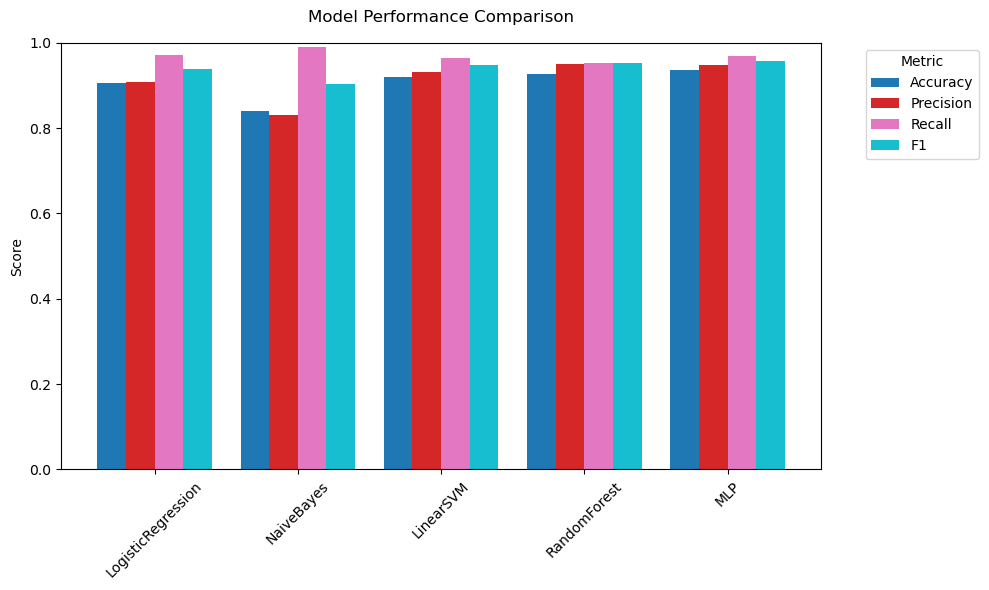

In [13]:
# Plotting the results Results 

plotDataset = resultOfData.set_index('Model')
metrics = ['Accuracy','Precision','Recall','F1']

ax = plotDataset[metrics].plot(kind='bar', figsize=(10,6), ylim=(0.0,1.0), width=0.8, rot=45, colormap='tab10')
ax.set_title('Model Performance Comparison', pad=15)
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


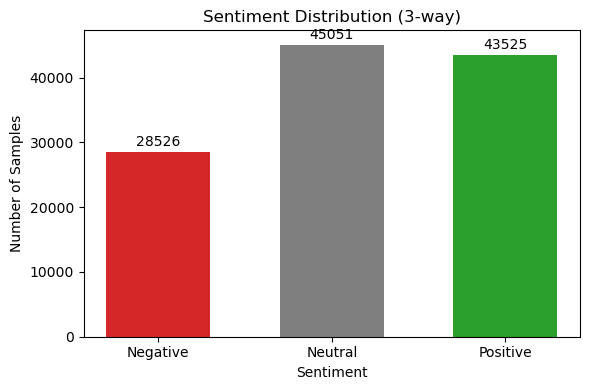

In [14]:
# Sentiment Analysis with 3-way classification

def three_way_sentiment(p):
    if p < 0:
        return 'Negative'
    elif p > 0:
        return 'Positive'
    else:
        return 'Neutral'
    
data['sentiment_3way'] = data['polarity'].apply(three_way_sentiment)

sent3_counts = data['sentiment_3way'].value_counts().reindex(['Negative','Neutral','Positive'])

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(sent3_counts.index, sent3_counts.values, color=['#d62728','#7f7f7f','#2ca02c'], width=0.6)

for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + sent3_counts.max()*0.01, f'{h}', ha='center', va='bottom')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Samples')
ax.set_title('Sentiment Distribution (3‐way)')
plt.tight_layout()
plt.show()


In [15]:
# Displaying 10 random samples with their sentiment scores and labels
np.random.seed(42)
sample_num = 10

indices = np.random.choice(data.index, sample_num, replace=False)

for i, idx in enumerate(indices, 1):
    ext = data.loc[idx, 'text']
    polarity = data.loc[idx, 'polarity']
    if polarity > 0:
        label = 'Positive'
    elif polarity < 0:
        label = 'Negative'
    else:
        label = 'Neutral'
    
    print(f"{i}.")
    print("Text: ", ext)
    print("Polarity score: ", polarity)
    print("Assigned Sentiment:", label)
    print("------------------")


1.
Text:  Further Ukrainian captures in Kherson Oblast: another T-62M tank and a BMP-1 IFV.
Polarity score:  0.0
Assigned Sentiment: Neutral
------------------
2.
Text:  They can't just keep sentencing everyone who doesn't speak ukrainian to death. There's plenty of people who live there and I don't think anyone is beng compensated for their service that doesn't live there. This is fucked.
Polarity score:  -0.10909090909090909
Assigned Sentiment: Negative
------------------
3.
Text:  Payback time.   
How is Ukraine with their electricity grid now? Hope all OK.
Polarity score:  0.5
Assigned Sentiment: Positive
------------------
4.
Text:  Euh, thanks for sharing ?
Polarity score:  0.2
Assigned Sentiment: Positive
------------------
5.
Text:  Dear Christ. Vile orc cunts. Let’s speed up their journey back to the fucking Stone Age.
Polarity score:  -0.3
Assigned Sentiment: Negative
------------------
6.
Text:  LMAO, you can't make this sh** up!
Polarity score:  0.75
Assigned Sentiment: Pos

In [16]:
# Topic Modeling with LDA

cv = CountVectorizer(max_features=5000, stop_words='english')
dtm = cv.fit_transform(posts['text'])
lda = LatentDirichletAllocation(n_components=10, random_state=42)
topics = lda.fit_transform(dtm)  # shape (n_posts,10)
posts['dominant_topic'] = topics.argmax(axis=1)


In [17]:
# Displaying the top words for each topic

features = posts['text']
targets = posts['dominant_topic']
featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=42)
vec = TfidfVectorizer(max_features=5000, stop_words='english')
Xtr = vec.fit_transform(featuresTrain); Xte = vec.transform(featuresTest)
topic_clf = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
topic_clf.fit(Xtr, targetTrain)
print(classification_report(targetTest, topic_clf.predict(Xte)))


              precision    recall  f1-score   support

           0       0.65      0.95      0.77       180
           1       0.64      0.48      0.55        60
           2       0.83      0.53      0.65        64
           3       0.65      0.75      0.70       109
           4       0.62      0.38      0.47        48
           5       0.62      0.63      0.63        76
           6       0.95      0.41      0.57        44
           7       0.80      0.36      0.50        44
           8       0.76      0.42      0.54        60
           9       0.44      0.64      0.52        74

    accuracy                           0.64       759
   macro avg       0.70      0.55      0.59       759
weighted avg       0.67      0.64      0.63       759



In [18]:
# Displaying the top terms for each topic

for i, comp in enumerate(lda.components_):
    terms = np.array(cv.get_feature_names_out())
    topTerms = terms[np.argsort(comp)[-10:]]
    print(f"Topic {i}: {', '.join(topTerms)}")


Topic 0: tank, soldier, ukraine, destroyed, artillery, soldiers, recently, forces, ukrainian, russian
Topic 1: lieutenant, ukrainian, russians, man, border, equipment, russia, military, ukraine, russian
Topic 2: tank, recently, new, army, training, russia, soldier, ukraine, russian, ukrainian
Topic 3: captured, kharkiv, oblast, forces, ukraine, army, region, kherson, russian, ukrainian
Topic 4: www, nuclear, com, war, abandoned, ukraine, russian, russia, https, putin
Topic 5: mariupol, defense, putin, ukrainian, like, russia, russians, war, ukraine, russian
Topic 6: putin, european, ukrainian, country, support, people, russia, russian, war, ukraine
Topic 7: 2022, aircraft, russia, war, fuck, president, today, ukraine, russian, ukrainian
Topic 8: explosion, crimea, video, state, ukrainian, ukraine, russian, crimean, russia, bridge
Topic 9: nato, don, world, just, people, russian, putin, war, russia, ukraine


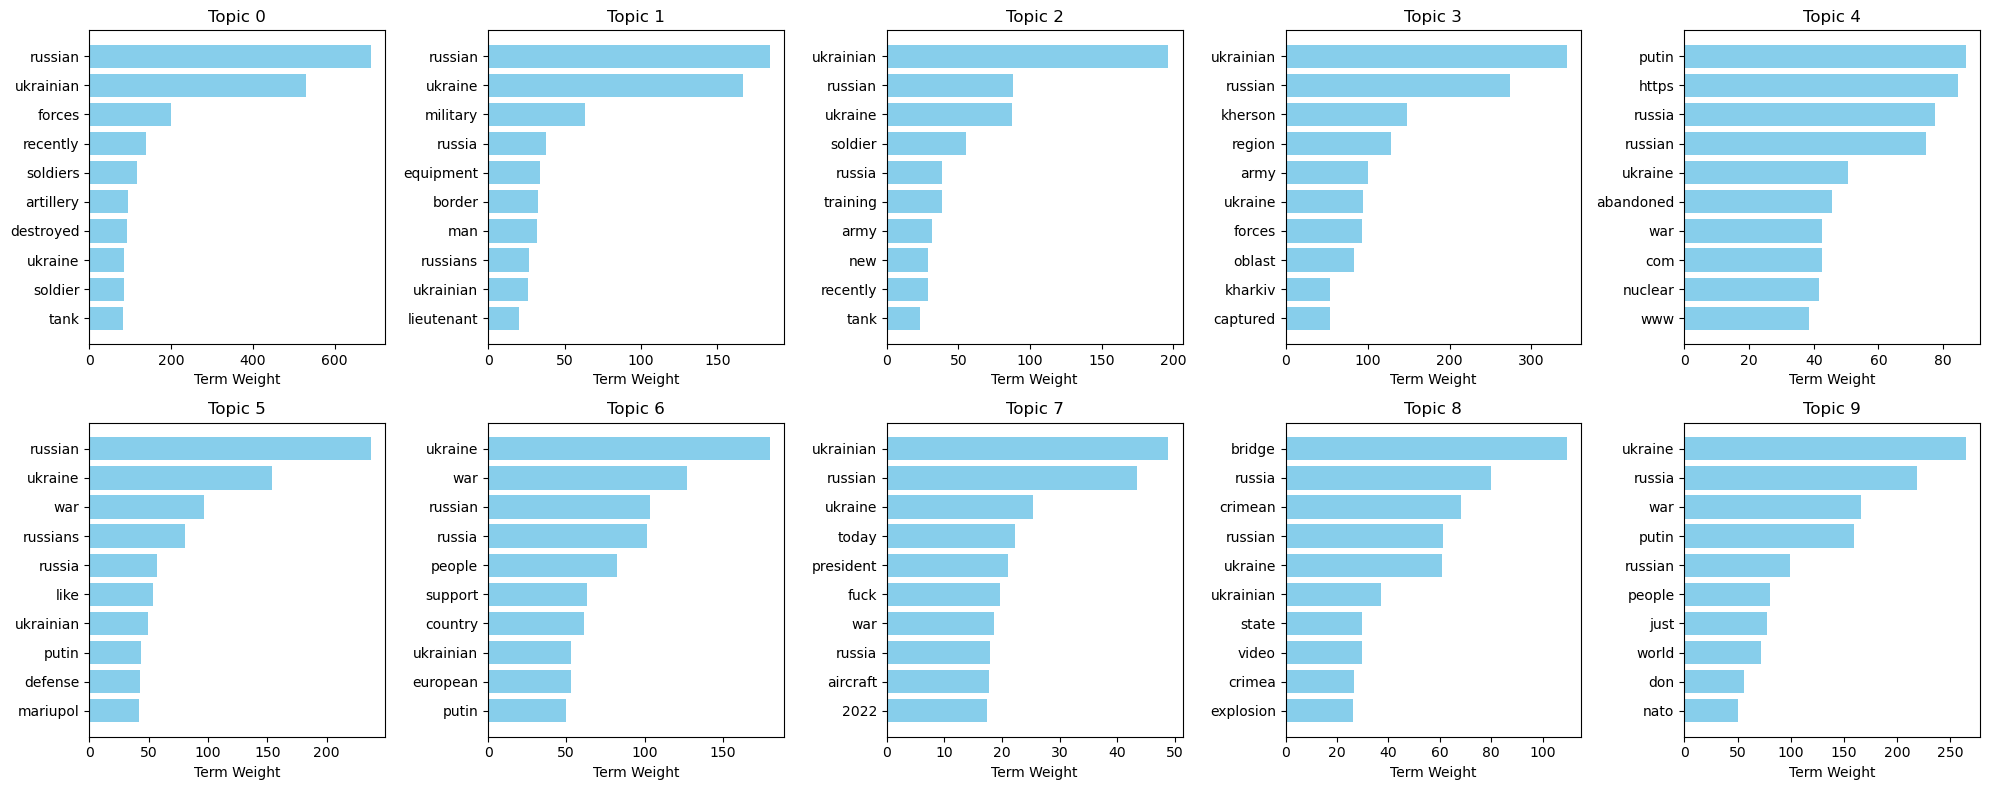

In [19]:
# Visualizing the top terms for each topic

n_topics = lda.components_.shape[0]
n_top    = 10
terms    = np.array(cv.get_feature_names_out())

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=False)
axes = axes.flatten()

for i, ax in enumerate(axes):
    comp = lda.components_[i]
    top_idx    = comp.argsort()[-n_top:][::-1]  
    top_terms  = terms[top_idx]
    top_scores = comp[top_idx]
    
    ax.barh(top_terms, top_scores, color='skyblue')
    ax.set_title(f"Topic {i}", fontsize=12)
    ax.invert_yaxis()  
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlabel("Term Weight")

plt.tight_layout()
plt.show()


In [1]:
# Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay

# For best sentiment model
best_model = models['MLP']
ConfusionMatrixDisplay.from_estimator(best_model, featureTest_tfidf, targetTest, cmap='Blues')
plt.title("Confusion Matrix - Sentiment Classification (MLP)")
plt.show()


NameError: name 'models' is not defined

In [ ]:
# Precision-Recall Curve

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

probs = best_model.predict_proba(featureTest_tfidf)[:, 1]
prec, rec, _ = precision_recall_curve(targetTest, probs)
disp = PrecisionRecallDisplay(precision=prec, recall=rec)
disp.plot()
plt.title("Precision-Recall Curve (MLP Sentiment)")
plt.show()


In [ ]:
# Wordcloud

from wordcloud import WordCloud

for i, comp in enumerate(lda.components_):
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(dict(zip(cv.get_feature_names_out(), comp)))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i} Word Cloud")
    plt.show()


In [ ]:
# Histogram

data['sentiment'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Sentiment Distribution (Binary)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=["Negative","Positive"])
plt.show()
